In [67]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#set seaborn plot display options
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

In [3]:
train = pd.read_csv('train_cleaned.csv', usecols=lambda col: col not in ['Unnamed: 0', 'id'])
train['saleprice'] = np.log1p(train['saleprice'])

# Feature engineering & selection

In [4]:
#numeric that are actually categorical
train = train.replace(
    {'mssubclass':{20:'subclasss20', 30:'subclass30', 40:'subclass40',
                   45:'subclass45', 50:'subclass50', 60:'subclass60',
                   70:'subclass70', 75:'subclass75', 80:'subclass80',
                   85:'subclass85', 90:'subclass90', 120:'subclass120',
                   150:'subclass150', 160:'subclass160', 180:'subclass180',
                   190:'subclass190'},
     'mosold':{1:'_01jan', 2:'_02feb', 3:'_03mar', 4:'_04apr', 5:'_05may',
               6:'_06jun', 7:'_07jul', 8:'_08aug', 9:'_09sep', 10:'_10oct',
               11:'_11nov', 12:'_12dec'}})

In [5]:
#separate subjective vars so easy to include or exclude (comment out)
train = train.replace({'lotshape':{'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}})
train = train.replace({'landcontour':{'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}})
train = train.replace({'landslope':{'Gtl':1, 'Mod':2, 'Sev':3}})
train = train.replace({'centralair':{'N':0, 'Y':1}})
train = train.replace({'garagetype':{'none':0, 'CarPort':1, 'Detchd':2,
                       'BuiltIn':3, 'Basment':4, 'Attchd':5, '2Types':6}})

train = train.replace(
    {'street':{'Grvl':1, 'Pave':2},
     'alley':{'none':0, 'Grvl':1, 'Pave':2},
     'utilities':{'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
     'exterqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'extercond':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtqual':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtcond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtexposure':{'none':0, 'No':0, 'Mn':2, 'Av':3, 'Gd':4},
     'bsmtfintype1':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'bsmtfintype2':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'heatingqc':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'kitchenqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'functional':{'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
     'fireplacequ':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagefinish':{'none':0, 'Unf':1, 'RFn':2, 'Fin':3},
     'garagequal':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagecond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'paveddrive':{'N':1, 'P':2, 'Y':2},
     'poolqc':{'none':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
     'fence':{'none':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}})

In [6]:
#create yr/mo sold feature
train['yrmo_sold'] = train.yrsold.astype(
    str).str.cat(train.mosold.astype(str))

#age of house at sale feature
train['age_at_sale'] = train['yrsold'] - train['yearbuilt']

In [8]:
cat_vars = train.dtypes[train.dtypes == 'object'].index.tolist()

#overallqual & overallcond were already in as numeric data
ord_vars = ['lotshape', 'landcontour', 'landslope', 'centralair', 'garagetype',
 'street', 'alley', 'utilities', 'exterqual', 'extercond', 'bsmtqual',
 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heatingqc',
 'kitchenqual', 'functional', 'fireplacequ', 'garagefinish', 'garagequal',
 'garagecond', 'paveddrive', 'poolqc', 'fence', 'overallqual', 'overallcond']
cont_vars = train.dtypes[train.dtypes != 'object'].index.tolist()
cont_vars = [x for x in cont_vars if x not in ord_vars]
cont_vars.remove('saleprice')

In [9]:
df_selected = pd.DataFrame(train[cat_vars])

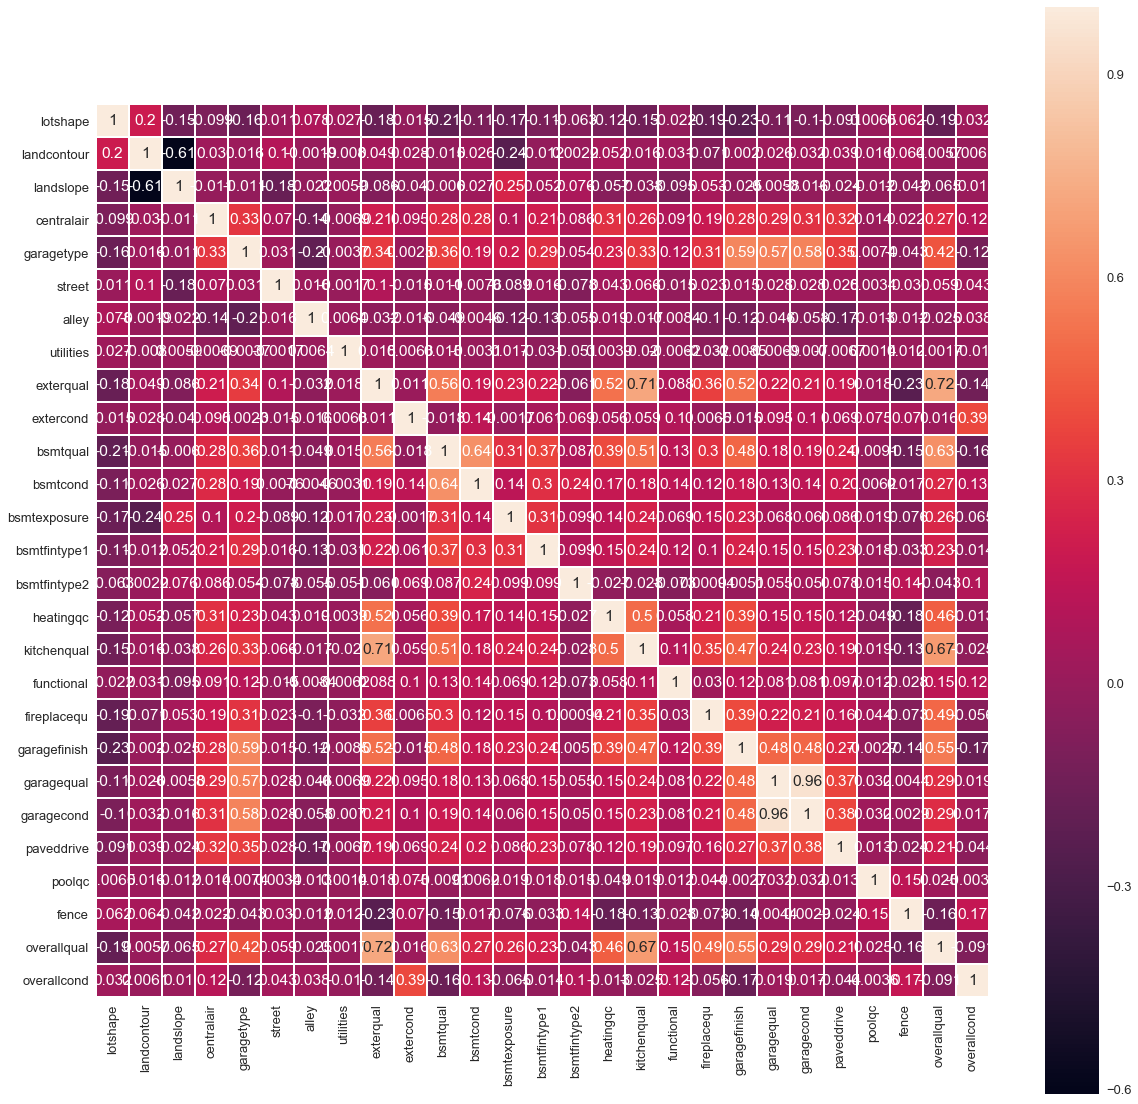

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(train[ord_vars].corr(),
            square=True, annot=True,
            linewidth=1, linecolor='white')
plt.show()

### Collinear Ordinal Variables:

- Xgaragetype: Xgaragefinish 0.59, Xgaragequal 0.57, Xgaragecond 0.58
- Xexterqual: Xbsmtqual 0.56, Xheatingqc 0.52, Xkitchenqual 0.71, Xgaragefinish 0.52
- Xbsmtqual: Xbsmtcond 0.64, Xkitchenqual 0.51
- Xgaragefinish: Xexterqual 0.52

Principle components:
- garage_pc : garagetype, garagefinish, garagequal, garagecond
- bsmt_pc : bsmtqual, bsmtcond
- ord_qual_pc : exterqual, heatingqc, kitchenqual, overallqual

In [11]:
stop

NameError: name 'stop' is not defined

In [12]:
garage_df = train[['garagetype', 'garagefinish', 'garagequal', 'garagecond']]
garage_std = StandardScaler().fit_transform(garage_df)
garage_pc = PCA(n_components=1).fit_transform(garage_std)
df_selected['garage_pc'] = garage_pc

In [13]:
bsmt_df = train[['bsmtqual', 'bsmtcond']]
bsmt_std = StandardScaler().fit_transform(bsmt_df)
bsmt_pc = PCA(n_components=1).fit_transform(bsmt_std)
df_selected['bsmt_pc'] = bsmt_pc

In [14]:
qual_df = train[['exterqual', 'heatingqc', 'kitchenqual', 'overallqual']]
qual_std = StandardScaler().fit_transform(qual_df)
qual_pc = PCA(n_components=1).fit_transform(qual_std)
df_selected['qual_pc'] = qual_pc

In [15]:
pca_ord_vars = ['garagetype', 'garagefinish', 'garagequal', 'garagecond',
                'bsmtqual', 'bsmtcond', 'exterqual', 'heatingqc',
                'kitchenqual', 'overallqual']
ords_to_add = [x for x in ord_vars if x not in pca_ord_vars]
ords_to_add

['lotshape',
 'landcontour',
 'landslope',
 'centralair',
 'street',
 'alley',
 'utilities',
 'extercond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'functional',
 'fireplacequ',
 'paveddrive',
 'poolqc',
 'fence',
 'overallcond']

In [18]:
df_selected[ords_to_add] = train[ords_to_add]

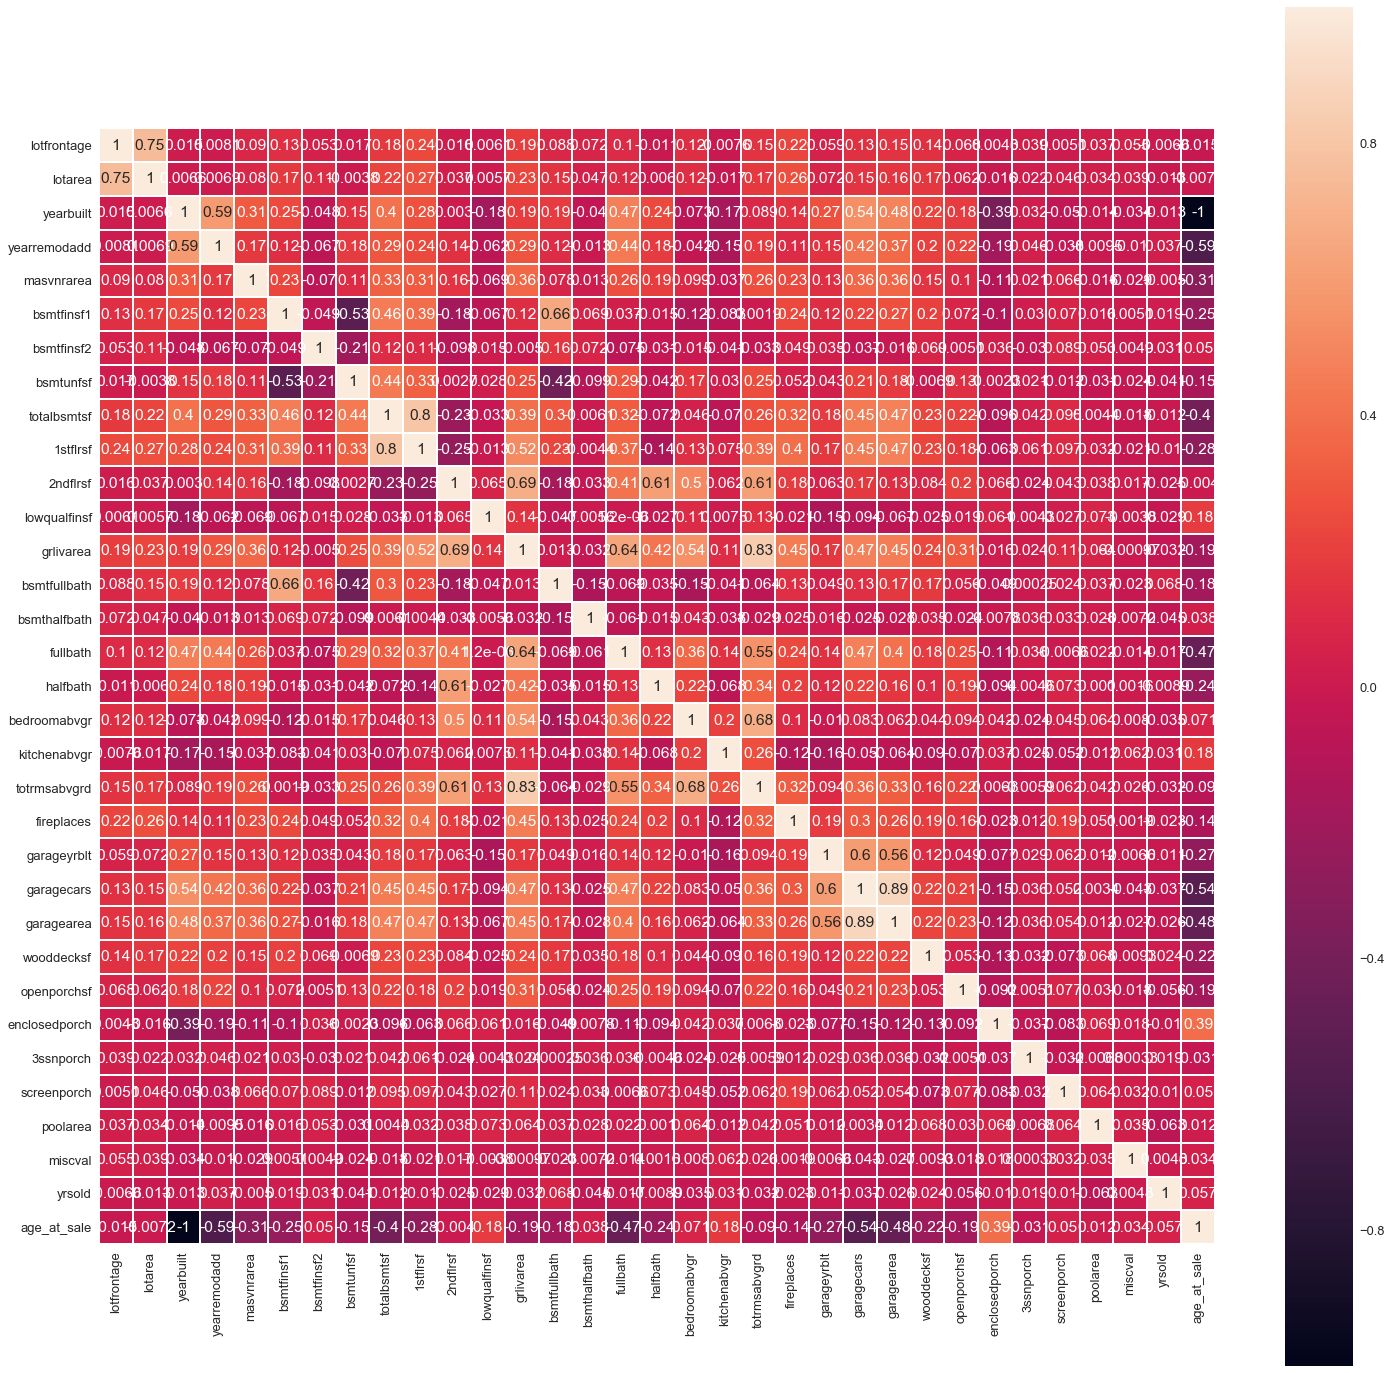

In [20]:
plt.figure(figsize=(25,25))
sns.heatmap(train[cont_vars].corr(),
            square=True, annot=True,
            linewidth=1, linecolor='white')
plt.show()

In [21]:
cont_corr = train[cont_vars].corr().unstack()
so = pd.DataFrame(cont_corr.sort_values(ascending=False))
so = so.reset_index()
so.columns = ['var1', 'var2', 'corr']
so = so[so['corr'] < 1]
so = so[(so['corr'] > 0.5) | (so['corr'] < -0.5)]
so.drop_duplicates(subset='corr', keep='first', inplace=True)
cont_corr = so.sort_values(by='corr', ascending=False)
cont_corr

,var1,var2,corr
33,garagearea,garagecars,0.886882
35,grlivarea,totrmsabvgrd,0.833979
37,totalbsmtsf,1stflrsf,0.800759
39,lotfrontage,lotarea,0.754767
41,grlivarea,2ndflrsf,0.687430
43,totrmsabvgrd,bedroomabvgr,0.679346
45,bsmtfullbath,bsmtfinsf1,0.661933
47,fullbath,grlivarea,0.635161
49,2ndflrsf,totrmsabvgrd,0.610794
51,2ndflrsf,halfbath,0.609022


In [23]:
#consider dropping lotfrontage as well since a fair amount was imputed anyway
lot_df = train[['lotarea', 'lotfrontage']]
lot_std = StandardScaler().fit_transform(lot_df)
lot_pc = PCA(n_components=1).fit_transform(lot_std)
df_selected['lot_pc'] = lot_pc

In [24]:
sf_df = train[['grlivarea', '1stflrsf', '2ndflrsf',
               'bsmtfinsf1', 'garagearea']]
sf_std = StandardScaler().fit_transform(sf_df)
sf_pc = PCA(n_components=1).fit_transform(sf_std)
df_selected['sf_pc'] = sf_pc

In [25]:
rm_df = train[['totrmsabvgrd', 'bedroomabvgr', 'bsmtfullbath',
               'fullbath', 'halfbath']]
rm_std = StandardScaler().fit_transform(rm_df)
rm_pc = PCA(n_components=1).fit_transform(rm_std)
df_selected['rm_pc'] = rm_pc

In [26]:
#vars included in cont PCA
pca_cont_vars = ['lotarea', 'lotfrontage', 'grlivarea', '1stflrsf', '2ndflrsf',
                 'bsmtfinsf1', 'garagearea', 'totrmsabvgrd', 'bedroomabvgr',
                 'bsmtfullbath', 'fullbath', 'halfbath']

conts_to_add = [x for x in cont_vars if x not in pca_cont_vars]
df_selected[conts_to_add] = train[conts_to_add]

In [28]:
df_selected.columns

Index(['mssubclass', 'mszoning', 'lotconfig', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'masvnrtype', 'foundation', 'heating',
       'electrical', 'miscfeature', 'mosold', 'saletype', 'salecondition',
       'yrmo_sold', 'garage_pc', 'bsmt_pc', 'qual_pc', 'lotshape',
       'landcontour', 'landslope', 'centralair', 'street', 'alley',
       'utilities', 'extercond', 'bsmtexposure', 'bsmtfintype1',
       'bsmtfintype2', 'functional', 'fireplacequ', 'paveddrive', 'poolqc',
       'fence', 'overallcond', 'lot_pc', 'sf_pc', 'rm_pc', 'yearbuilt',
       'yearremodadd', 'masvnrarea', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'lowqualfinsf', 'bsmthalfbath', 'kitchenabvgr', 'fireplaces',
       'garageyrblt', 'garagecars', 'wooddecksf', 'openporchsf',
       'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
       'yrsold', 'age_at_sale'],
      dtype='object')

# Modeling

In [29]:
df_selected = pd.get_dummies(df_selected)
X = df_selected
y = train['saleprice']

def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'))
    return(rmse)

## Ridge

In [30]:
ridge = RidgeCV(
    alphas=[0.01, 0.05, 0.1, 0.5, 1, 5]
).fit(X, y)

alpha = ridge.alpha_
print('model: ridge')
print('alpha:', alpha)
print('rmse score mean:', rmse(ridge).mean())
print('rmse max - rmse min:', rmse(ridge).max() - rmse(ridge).min())
print('rmse score array:', rmse(ridge))

model: ridge
alpha: 5.0
rmse score mean: 0.11834168914707285
rmse max - rmse min: 0.01410462362220391
rmse score array: [0.11737338 0.12600419 0.12248595 0.11189957 0.11394535]


In [31]:
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
alpha = ridge.alpha_
print('model: ridge')
print('alpha:', alpha)
print('cross_val rmse mean:', rmse(ridge).mean())
print('rmse max - rmse min:', rmse(ridge).max() - rmse(ridge).min())
print('rmse score array:', rmse(ridge))

model: ridge
alpha: 10.0
cross_val rmse mean: 0.11788942752090643
rmse max - rmse min: 0.01441107296435147
rmse score array: [0.11755659 0.12601787 0.12114348 0.1116068  0.1131224 ]


## Lasso

In [70]:
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('model: lasso')
print('alpha: ', alpha)
print('rmse score mean:', rmse(lasso).mean())
print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
print('rmse score array:', rmse(lasso))

model: lasso
alpha:  0.0005
rmse score mean: 0.11554540335398826
rmse max - rmse min: 0.016719842674447052
rmse score array: [0.11495644 0.1243999  0.1200249  0.10768006 0.11066571]


In [71]:
lasso = LassoCV(alphas=[alpha,
                        alpha*0.25, alpha*0.5, alpha*0.75,
                        alpha*1.25, alpha*1.5, alpha*1.75, alpha*2])

lasso.fit(X, y)
alpha = lasso.alpha_
print('model: lasso')
print('alpha: ', alpha)
print('rmse score mean:', rmse(lasso).mean())
print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
print('rmse score array:', rmse(lasso))

model: lasso
alpha:  0.000375
rmse score mean: 0.11573210177781335
rmse max - rmse min: 0.017361642707318548
rmse score array: [0.11495644 0.1250417  0.1200249  0.10768006 0.1109574 ]


## Elastic Net (combined L1 & L2 priors as regularizer)

In [69]:
start_time = time.clock()
el_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
            0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
    cv=5
).fit(X,y)
l1_ratio = el_net.l1_ratio_
alpha = el_net.alpha_
print('l1 ratio: ', l1_ratio)
print('alpha: ', alpha)
print('rmse score mean: ', rmse(el_net).mean())
print('rmse max - rmse min:', rmse(el_net).max() - rmse(el_net).min())
print('rmse score array:', rmse(el_net))

l1 ratio:  0.7
alpha:  0.0006
rmse score mean:  0.11567076929526106
rmse max - rmse min: 0.01738900760142402
rmse score array: [0.11463506 0.12462725 0.12100136 0.10723825 0.11085193]


## Random Forest

In [35]:
len(df_selected.columns)

277

In [36]:
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, len(df_selected.columns)],
           'max_depth':[10,20,30,40]}]

start_time = time.clock()
grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)

print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'max_depth': 40, 'max_features': 277, 'n_estimators': 100}
runtime:  171.630459


In [37]:
n_estimators = grid.best_params_.get('n_estimators')
max_depth = grid.best_params_.get('max_depth')
max_features = grid.best_params_.get('max_features')

start_time = time.clock()
rfr = ensemble.RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features
).fit(X, y)

print('model: random forest')
print('rmse score mean:', rmse(rfr).mean())
print('rmse max - rmse min:', rmse(rfr).max() - rmse(rfr).min())
print('rmse score array:', rmse(rfr))
print('runtime: ', time.clock() - start_time)

model: random forest
rmse score mean: 0.1313452037625766
rmse max - rmse min: 0.022059633881312046
rmse score array: [0.12317556 0.14333989 0.13582764 0.12515058 0.1286947 ]
runtime:  37.99650299999999


## XGBoost

In [38]:
#vanilla
start_time = time.clock()
xgbr = XGBRegressor().fit(X, y)
print('model: vanilla xgb_rgr')
print('cross_val rmse mean:', rmse(xgbr).mean())
print('rmse max - rmse min:', rmse(xgbr).max() - rmse(xgbr).min())
print('rmse score array:', rmse(xgbr))
print('runtime: ', time.clock() - start_time)

model: vanilla xgb_rgr
cross_val rmse mean: 0.12460145268546752
rmse max - rmse min: 0.010771891494075744
rmse score array: [0.12086738 0.12781121 0.13089238 0.12012048 0.12331582]
runtime:  13.089718999999974


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [62]:
#get rounds
xgbr = XGBRegressor(n_estimators=1000)

xgbr.fit(X_train, y_train,
      early_stopping_rounds=5, eval_metric='rmse',
      eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-rmse:10.3559
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:9.32001
[2]	validation_0-rmse:8.38784
[3]	validation_0-rmse:7.55061
[4]	validation_0-rmse:6.79627
[5]	validation_0-rmse:6.11858
[6]	validation_0-rmse:5.50742
[7]	validation_0-rmse:4.95756
[8]	validation_0-rmse:4.46283
[9]	validation_0-rmse:4.0175
[10]	validation_0-rmse:3.61615
[11]	validation_0-rmse:3.25512
[12]	validation_0-rmse:2.93146
[13]	validation_0-rmse:2.6398
[14]	validation_0-rmse:2.37685
[15]	validation_0-rmse:2.14043
[16]	validation_0-rmse:1.92772
[17]	validation_0-rmse:1.7365
[18]	validation_0-rmse:1.56463
[19]	validation_0-rmse:1.41
[20]	validation_0-rmse:1.27008
[21]	validation_0-rmse:1.14466
[22]	validation_0-rmse:1.03188
[23]	validation_0-rmse:0.931144
[24]	validation_0-rmse:0.840002
[25]	validation_0-rmse:0.758394
[26]	validation_0-rmse:0.685715
[27]	validation_0-rmse:0.620309
[28]	validation_0-rmse:0.560981
[29]	validation_0-rmse:0.509119
[30]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
#tuned
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'n_estimators':[500,750,1000],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

start_time = time.clock()
grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)

print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

KeyboardInterrupt: 

In [40]:
booster = grid.best_params_.get('booster')
learning_rate = grid.best_params_.get('learning_rate')
max_depth = grid.best_params_.get('max_depth')
subsample = grid.best_params_.get('subsample')

start_time = time.clock()
xgb_rgr = XGBRegressor(
    n_estimators=1000,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample
).fit(X, y, verbose=False)

print('model: xgboost regressor')
print('cross_val rmse mean:', rmse(xgbr).mean())
print('rmse max - rmse min:', rmse(xgbr).max() - rmse(xgbr).min())
print('rmse score array:', rmse(xgbr))
print('runtime: ', time.clock() - start_time)

model: xgboost regressor
cross_val rmse mean: 0.12460145268546752
rmse max - rmse min: 0.010771891494075744
rmse score array: [0.12086738 0.12781121 0.13089238 0.12012048 0.12331582]
runtime:  22.323767999999973
